In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# 데이터 로드

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 100

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


# 이미지 데이터 전처리
- 파일명을 바탕으로 레이블 처리
- 이미지 데이터 float32로 변환
- dataset format로 변환

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정    
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds_ori = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_ori = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)



train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds_1 = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_1 = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 shape, 레이블 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
# Dataset으로 만들어줌
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# 트레이닝 전 전처리 순서 셔플
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

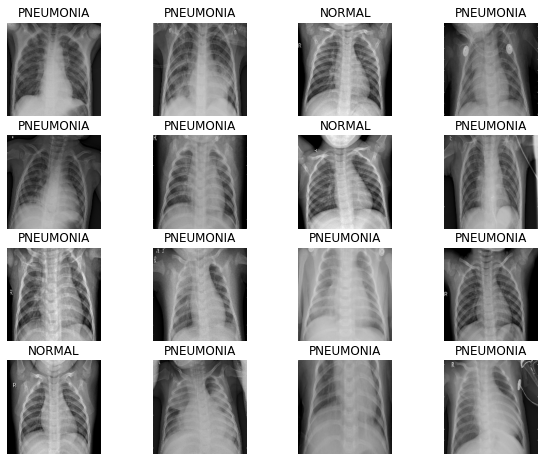

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 모델링
- conv : conv2D + conv2D + Batchnormal + MaxPool
- dense : Dense, Batchnormal + Dropout

In [16]:
# conv 블럭 모델링
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# dense_block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
# imbalance data 가중치 부여
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 학습
- 100에폭 설정 early stopping을 통해 스탑을 걸어줌

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# early stopping 사용 val_loss를 통해서 사용
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5)]

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks
    )

Epoch 1/100
261/261 [==============================] - 56s 135ms/step - loss: 0.5043 - accuracy: 0.7481 - precision: 0.9250 - recall: 0.7155 - val_loss: 0.8346 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 34s 130ms/step - loss: 0.2346 - accuracy: 0.9097 - precision: 0.9656 - recall: 0.9104 - val_loss: 1.6786 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 34s 130ms/step - loss: 0.2329 - accuracy: 0.9231 - precision: 0.9790 - recall: 0.9182 - val_loss: 0.7601 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/100
261/261 [==============================] - 34s 130ms/step - loss: 0.1946 - accuracy: 0.9306 - precision: 0.9772 - recall: 0.9298 - val_loss: 0.0815 - val_accuracy: 0.9712 - val_precision: 0.9778 - val_recall: 0.9830
Epoch 5/100
261/261 [==============================] - 34s 130ms/step - loss: 0.1301 - a

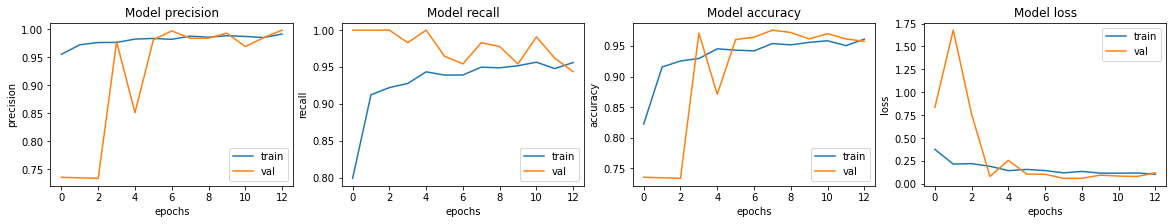

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 결과 확인
- evaluation 결과 0.8 정확도

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.6567 - accuracy: 0.8462 - precision: 0.8141 - recall: 0.9769
Loss: 0.6567413210868835,
Accuracy: 0.8461538553237915,
Precision: 0.8141025900840759,
Recall: 0.9769230484962463


# Data augment
- random하게 좌우 반전, 상하 반전을 해서 과적합을 피해 줌.
- 두가지 케이스에 대해 학습 진행

In [25]:
import random
def augment(image,label):   
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def augment2(image,label):
    image = tf.image.random_flip_up_down(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def augment3(image,label):
    #random 해서 짝수면 좌우 반전 홀수면 상하 반전
    idx = random.randrange(1,7)
    if idx % 2 == 0:
        image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    else:
        image = tf.image.random_flip_up_down(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
def prepare_for_training2(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment2,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def prepare_for_training3(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment2,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_1 = prepare_for_training(train_ds_ori)
val_ds_1 = prepare_for_training(val_ds_ori)

train_ds_2 = prepare_for_training2(train_ds_ori)
val_ds_2 = prepare_for_training2(val_ds_ori)

train_ds_3 = prepare_for_training3(train_ds_ori)
val_ds_3 = prepare_for_training3(val_ds_ori)

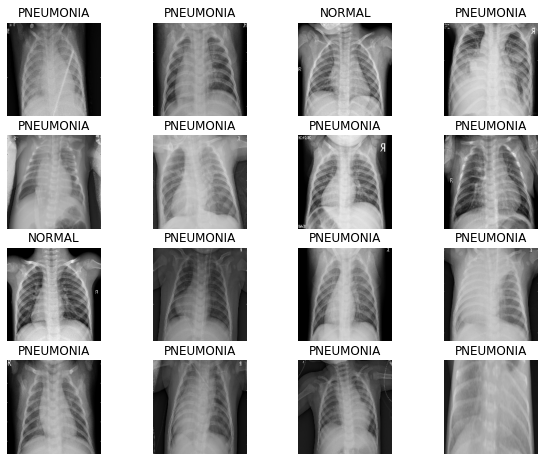

In [26]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_1))
show_batch(image_batch.numpy(), label_batch.numpy())

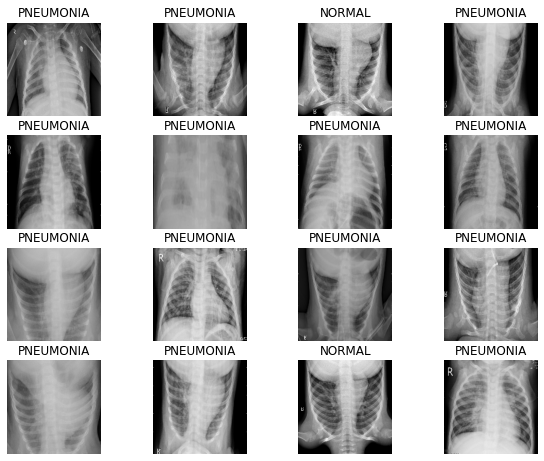

In [27]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_2))
show_batch(image_batch.numpy(), label_batch.numpy())

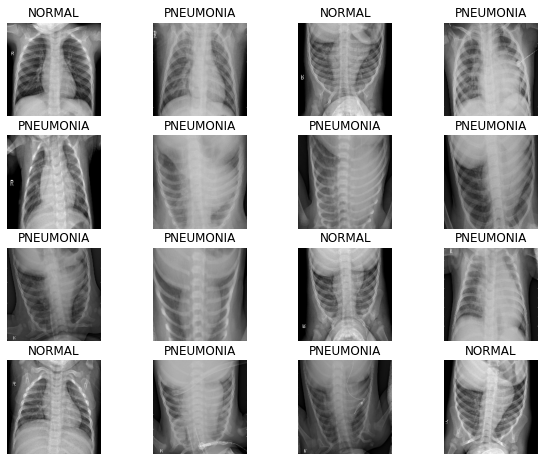

In [28]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_3))
show_batch(image_batch.numpy(), label_batch.numpy())

In [29]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
# 상하 반전 이미지를 통해 학습 진행
with tf.device('/GPU:0'):
    model1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
# 상하,좌우 반전 이미지를 통해 학습 진행
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
# 좌우 반전 데이터셋을 통해 학습 진행
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks
    )

Epoch 1/100
261/261 [==============================] - 42s 132ms/step - loss: 0.5269 - accuracy: 0.7212 - precision: 0.9170 - recall: 0.6801 - val_loss: 0.6830 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 34s 129ms/step - loss: 0.2340 - accuracy: 0.9032 - precision: 0.9751 - recall: 0.8934 - val_loss: 1.5982 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 34s 129ms/step - loss: 0.1981 - accuracy: 0.9207 - precision: 0.9777 - recall: 0.9137 - val_loss: 0.2834 - val_accuracy: 0.8692 - val_precision: 0.8491 - val_recall: 1.0000
Epoch 4/100
261/261 [==============================] - 34s 129ms/step - loss: 0.1842 - accuracy: 0.9323 - precision: 0.9765 - recall: 0.9314 - val_loss: 0.2527 - val_accuracy: 0.9221 - val_precision: 0.9957 - val_recall: 0.8980
Epoch 5/100
261/261 [==============================] - 34s 129ms/step - loss: 0.1580 - a

In [33]:
with tf.device('/GPU:0'):
    history1 = model1.fit(
        train_ds_2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks
    )

Epoch 1/100
261/261 [==============================] - 41s 131ms/step - loss: 0.5433 - accuracy: 0.7154 - precision: 0.9054 - recall: 0.6846 - val_loss: 0.6891 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 34s 129ms/step - loss: 0.2627 - accuracy: 0.8972 - precision: 0.9771 - recall: 0.8818 - val_loss: 1.1247 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 34s 129ms/step - loss: 0.2083 - accuracy: 0.9209 - precision: 0.9769 - recall: 0.9151 - val_loss: 0.1204 - val_accuracy: 0.9606 - val_precision: 0.9738 - val_recall: 0.9725
Epoch 4/100
261/261 [==============================] - 34s 128ms/step - loss: 0.2031 - accuracy: 0.9237 - precision: 0.9795 - recall: 0.9169 - val_loss: 0.2025 - val_accuracy: 0.9317 - val_precision: 0.9915 - val_recall: 0.9149
Epoch 5/100
261/261 [==============================] - 34s 129ms/step - loss: 0.1892 - a

In [34]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds_3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks
    )

Epoch 1/100
261/261 [==============================] - 42s 131ms/step - loss: 0.5761 - accuracy: 0.7009 - precision: 0.9048 - recall: 0.6648 - val_loss: 0.6476 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/100
261/261 [==============================] - 34s 130ms/step - loss: 0.3411 - accuracy: 0.8598 - precision: 0.9616 - recall: 0.8446 - val_loss: 1.0129 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/100
261/261 [==============================] - 34s 129ms/step - loss: 0.2877 - accuracy: 0.8866 - precision: 0.9710 - recall: 0.8733 - val_loss: 0.1692 - val_accuracy: 0.9413 - val_precision: 0.9512 - val_recall: 0.9699
Epoch 4/100
261/261 [==============================] - 33s 128ms/step - loss: 0.2573 - accuracy: 0.8937 - precision: 0.9638 - recall: 0.8901 - val_loss: 0.1457 - val_accuracy: 0.9490 - val_precision: 0.9837 - val_recall: 0.9463
Epoch 5/100
261/261 [==============================] - 34s 130ms/step - loss: 0.2474 - a

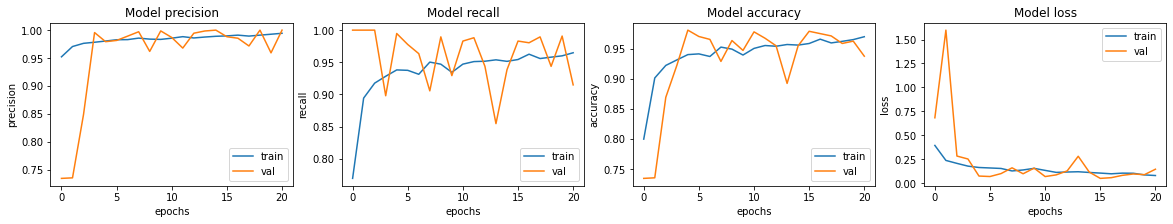

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

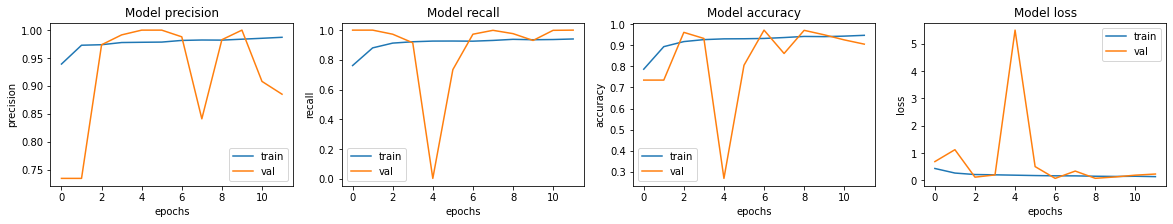

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history1.history[met])
    ax[i].plot(history1.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

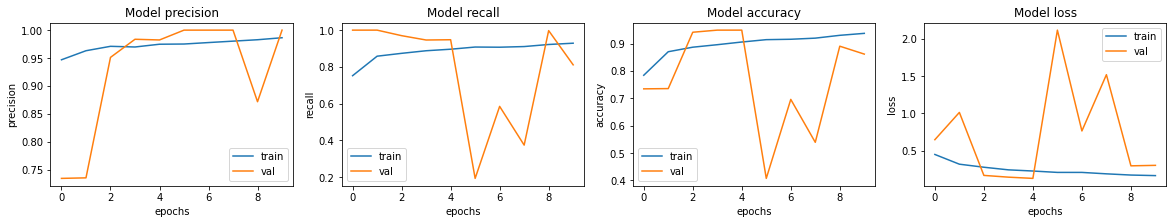

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.5732 - accuracy: 0.8510 - precision: 0.8278 - recall: 0.9615
Loss: 0.5731869339942932,
Accuracy: 0.8509615659713745,
Precision: 0.8278145790100098,
Recall: 0.9615384340286255


In [39]:
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 1.4410 - accuracy: 0.6763 - precision: 0.6588 - recall: 1.0000
Loss: 1.440958857536316,
Accuracy: 0.6762820482254028,
Precision: 0.6587837934494019,
Recall: 1.0


In [40]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.3535 - accuracy: 0.8574 - precision: 0.8950 - recall: 0.8744
Loss: 0.3534582555294037,
Accuracy: 0.8573718070983887,
Precision: 0.8950130939483643,
Recall: 0.8743589520454407


# 모바일넷을 통한 전이학습 실험

In [41]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers


# Pretrained MobileNet 사용

In [42]:
IMG_SIZE = 180
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [43]:
print(train_ds)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
(16, 6, 6, 1280)


In [44]:
# 이미 학습이 되었으므로 분류기만 학습을 할 경우 가중치를 갱신하지 않음
base_model.trainable = False

In [45]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# 분류기 layer 추가
- global averatge pooling layer 추가
- 분류용 Dense layer 추가

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [47]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [48]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# 최종 모델
- 기존 MobileNet에 pooling layer + Dense layer 추가

In [50]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [51]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=callbacks
    )

Epoch 1/100
261/261 [==============================] - 56s 119ms/step - loss: 7.3919 - accuracy: 0.2667 - val_loss: 2.9948 - val_accuracy: 0.5096
Epoch 2/100
261/261 [==============================] - 30s 116ms/step - loss: 2.4403 - accuracy: 0.6336 - val_loss: 0.9972 - val_accuracy: 0.7788
Epoch 3/100
261/261 [==============================] - 30s 117ms/step - loss: 1.0367 - accuracy: 0.8137 - val_loss: 0.5891 - val_accuracy: 0.8769
Epoch 4/100
261/261 [==============================] - 30s 117ms/step - loss: 0.5496 - accuracy: 0.8738 - val_loss: 0.4895 - val_accuracy: 0.9154
Epoch 5/100
261/261 [==============================] - 31s 119ms/step - loss: 0.4814 - accuracy: 0.9038 - val_loss: 0.5021 - val_accuracy: 0.9183
Epoch 6/100
261/261 [==============================] - 32s 122ms/step - loss: 0.4158 - accuracy: 0.9128 - val_loss: 0.5640 - val_accuracy: 0.9192
Epoch 7/100
261/261 [==============================] - 34s 129ms/step - loss: 0.4684 - accuracy: 0.9272 - val_loss: 0.4498 -

In [52]:
# loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
loss, accuracy= model.evaluate(test_ds)

39/39 [==============================] - 5s 119ms/step - loss: 0.8121 - accuracy: 0.8926


In [53]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

initial loss: 0.81
initial accuracy: 0.89


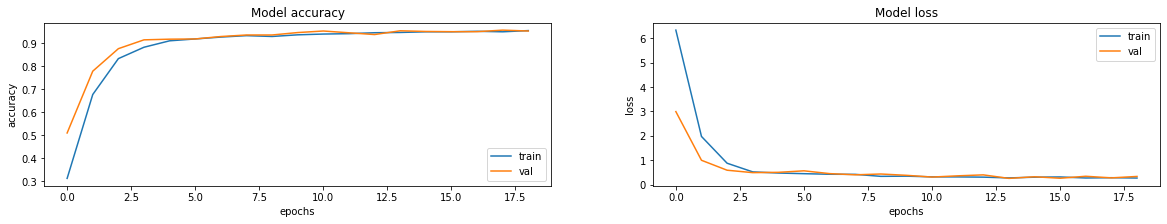

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 결과
- 일반 좌우반전을 한것보다는 상하 좌우 반전을 같이 사용한 것이 약간의 성능 향상을 보였다.
- 또한 Mobilenet을 base모델로 하여 Image net을 통해 학습된 pretrained 모델을 사용해서 분류기만 새로학습할경우 89%의 정확도를 보임.

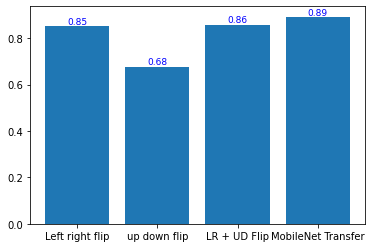

In [60]:
 
models = ['Left right flip', 'up down flip', 'LR + UD Flip', 'MobileNet Transfer']
test_acc = [0.8509615659713745,0.6762820482254028,0.8573718070983887,0.8926]
x = np.arange(4)
plt.bar(x, test_acc)
plt.xticks(x, models)

for i, v in enumerate(x):
    plt.text(v, round(test_acc[i],2), round(test_acc[i],2),                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)


plt.show()